In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

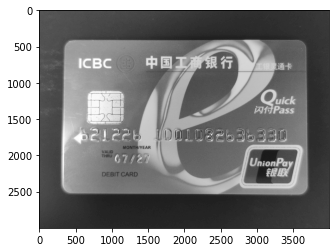

In [3]:
img = cv2.imread('img/card3.jpg', 0)
# img = cv2.imread('img/card4.jpeg', 0)
plt.imshow(img, 'gray')

# 去除多余背景removeBackground

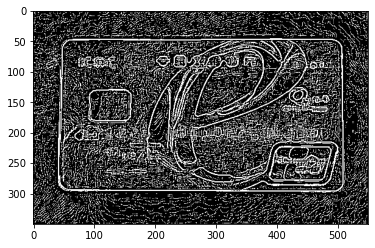

In [4]:
img = cv2.resize(img, (550, 350), 0, 0, cv2.INTER_NEAREST)
blur = cv2.medianBlur(img, 9)
# 边缘检测的目的是标识数字图像中亮度变化明显的点。
x = cv2.Sobel(blur, cv2.CV_32F, 1, 0, 3)
y = cv2.Sobel(blur, cv2.CV_32F, 0, 1, 3)
absX = cv2.convertScaleAbs(x)  # 转为uint8格式
absY = cv2.convertScaleAbs(y)
# Sobel算子是在两个方向计算的，最后还需要用cv2.addWeighted( )函数将其组合起来。
sobel = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
# 自适应二值化
thresh = cv2.adaptiveThreshold(sobel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3,0)

plt.imshow(thresh, 'gray')

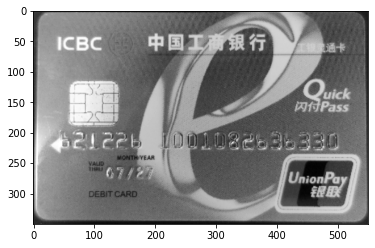

In [5]:
# 找到最大连通区域
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

temp = 0
W = 0
H = 0
X = 0
Y = 0
for i in range(0,len(cnts)):
    x,y,w,h = cv2.boundingRect(cnts[i])
    if(temp <w + h):    
        temp = w+h
        W = w
        H = h
        X = x
        Y = y  
remove_back_img = img[Y:Y+H,X:X+W]

img_r = cv2.resize(remove_back_img,(550, 350),cv2.INTER_NEAREST)
plt.imshow(img_r, 'gray')

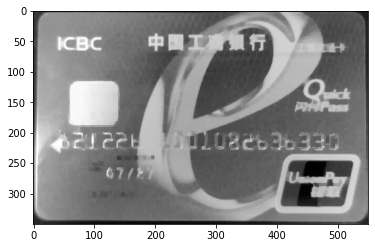

In [6]:
# 膨胀腐蚀
dilate = cv2.dilate(img_r, None, iterations=2)
erosion = cv2.erode(dilate, None, iterations=2)
plt.imshow(erosion, 'gray')

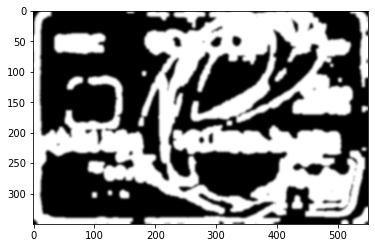

In [7]:
sobel_x = cv2.Sobel(erosion,cv2.CV_32F,1,0,3) #边缘检测
sobel_y = cv2.Sobel(erosion,cv2.CV_32F,0,1,3)
absX = cv2.convertScaleAbs(sobel_x)
absY = cv2.convertScaleAbs(sobel_y)
sobel_img = cv2.addWeighted(absX,0.5,absY,0.5,0)
sobel_img = cv2.medianBlur(sobel_img,11)  #中值模糊
sobel_img = cv2.dilate(sobel_img,None,iterations=2) #膨胀

_,threshold = cv2.threshold(sobel_img,10,255,cv2.THRESH_BINARY) #二值化
threshold = cv2.GaussianBlur(threshold,(9,9),0) #高斯模糊

plt.imshow(threshold, 'gray')

在信用卡中部寻找黑点最少的区域，为卡号所在区域

In [8]:
H, W = img_r.shape 
hor_array = np.zeros(H, np.int32)

for j in range(0, H):
    for i in range(0, W):
        if threshold[j, i] == 0:
            hor_array[j] += 1



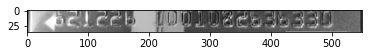

In [9]:
H = len(hor_array)
label_H = int(H / 10)
min_ = sum(hor_array)
ans = 0
for i in range(int(0.5 * H) - label_H):
    a = int(2/5 * H) + i
    b = int(2/5 * H) + i + label_H
    mean = hor_array[a:b].mean()
    if mean < min_:
        ans = a
        min_ = mean 
    if a > 0.6 * H:
        card_num = img_r[ans:ans+label_H]
        
plt.imshow(card_num, 'gray')

将两侧的无用面积尽可能缩小

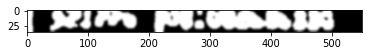

In [10]:
sobel_x = cv2.Sobel(card_num,cv2.CV_32F,1,0,3) #边缘检测
sobel_y = cv2.Sobel(card_num,cv2.CV_32F,0,1,3)
absX = cv2.convertScaleAbs(sobel_x)
absY = cv2.convertScaleAbs(sobel_y)
sobel_img = cv2.addWeighted(absX,0.5,absY,0.5,0)
sobel_img = cv2.medianBlur(sobel_img,11)  #中值模糊
sobel_img = cv2.dilate(sobel_img,None,iterations=2) #膨胀

_,threshold = cv2.threshold(sobel_img,50,255,cv2.THRESH_BINARY) #二值化
threshold = cv2.GaussianBlur(threshold,(9,9),0) #高斯模糊
 
plt.imshow(threshold, 'gray')

In [2]:
def embossment(self,img):
    H,W = img.shape
    dst = np.zeros((H,W),np.uint8)
    for i in range(0,H):
        for j in range(0,W-1):
            grayP0 = int(img[i,j])
            grayP1 = int(img[i,j+1])
            newP = grayP0 - grayP1 + 150
            if newP > 255:
                newP = 255
            if newP < 0:
                newP = 0
            dst[i,j] = newP
    return dst

In [11]:
def getNumberArea(img):
    num_img = img
    h,w,_ = num_img.shape
    gray_img = cv2.cvtColor(num_img,cv2.COLOR_BGR2GRAY)
    dilate_img= embossment(gray_img)
    embo_img = cv2.medianBlur(dilate_img,3)
    _,thresh_img= cv2.threshold(embo_img,155,255,cv2.THRESH_BINARY)

        
    thresh_img = cv2.medianBlur(thresh_img,3)
    thresh_img = cv2.GaussianBlur(thresh_img,(3,3),0)
    thresh_img = cv2.dilate(thresh_img,None,iterations=10)

    _,thresh_img= cv2.threshold(thresh_img,220,255,cv2.THRESH_BINARY)
    a = np.zeros(w,np.uint8)
    for j in range(0,w): #计算水平方向上的黑色像素点数目，
        for i in range(0,h):
            if  thresh_img[i,j] == 0: 
                a[j] += 1
        
    a = a[::-1]
    length = int(0.75 * w)
    min_ = sum(a)
    start = 0
    for i in range(len(a)):
        if a[i] < 15:
            a[i] = 0
        else:
            a[i] = 35
    for i in range(w - length):
        end = i + length 
        mean_ = a[i:end].mean()
        if(min_ > mean_ and i < 50):
            min_ = mean_
            start = i
    end = w - start 
    a = a[::-1]
    min_ = sum(a)
    start = 0
    for i in range(130):
        mean_ = a[i:end].mean()
        if min_ > mean_:
            min_ = mean_
            start = i
    # print(start,end)
    W_end = end + 20
    W_start = start + 25
    # cv2.imshow('aaa',num_img[:,start:end+10])
    return num_img[:,start+5:end]